# 時系列予測モデルのONNX変換デモ

このノートブックでは以下を実行します：
1. **実データの読み込み** - 航空旅客数データ（1949-1960）
2. **scikit-learnモデルのトレーニング** - RandomForestで時系列予測
3. **ONNXへの変換** - モデルをONNX形式に変換
4. **ONNX推論の実行と精度検証** - scikit-learnとONNXの予測結果を比較
5. **結果の可視化** - 予測結果、残差分析、誤差分析

In [27]:
!uv add scikit-learn skl2onnx onnxruntime onnx pandas numpy matplotlib seaborn jupyter statsmodels

print("✓ パッケージのインストールと追加が完了しました")
print("⚠ カーネルを再起動してください（Kernel > Restart）")

✓ パッケージのインストールと追加が完了しました
⚠ カーネルを再起動してください（Kernel > Restart）


Resolved 130 packages in 1ms
Audited 126 packages in 8ms


## 1. ライブラリのインポート

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import pickle
import warnings

In [29]:
warnings.filterwarnings('ignore')

# スタイル設定
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'MS Gothic'  # 日本語フォント
plt.rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

print("✓ ライブラリのインポート完了")

✓ ライブラリのインポート完了


## 2. 実データの読み込み：航空旅客数データ

1949年〜1960年の月次国際航空旅客数データを使用します。
- **トレンド**: 時間とともに増加
- **季節性**: 夏季に増加、冬季に減少
- **実際のビジネスデータ**: 解釈しやすく、需要予測の典型例


In [30]:
def load_and_prepare_airline_data(window_size=12):
    """
    航空旅客数データを読み込み、特徴量エンジニアリング
    
    Parameters:
    - window_size: 過去何ヶ月のデータを特徴量として使用するか（デフォルト12=1年）
    """
    # 航空旅客数データの読み込み
    data = sm.datasets.get_rdataset("AirPassengers", "datasets")
    air_passengers = data.data
    
    # 時系列値を取得
    values = air_passengers['value'].values
    time_index = np.arange(len(values))
    
    print(f"データ期間: 1949年1月 〜 1960年12月")
    print(f"総サンプル数: {len(values)} ヶ月")
    print(f"値の範囲: {values.min():.0f} 〜 {values.max():.0f} (千人)")
    
    # 特徴量の作成（ラグ特徴量）
    features = []
    targets = []
    valid_time_index = []
    
    for i in range(window_size, len(values)):
        # 過去window_size時点のデータを特徴量として使用
        lag_features = values[i-window_size:i]
        
        # 追加の統計的特徴量
        mean_val = np.mean(lag_features)
        std_val = np.std(lag_features)
        min_val = np.min(lag_features)
        max_val = np.max(lag_features)
        trend_val = lag_features[-1] - lag_features[0]  # 直近の変化
        
        # 季節性の特徴量（月）
        month = i % 12  # 0-11の月インデックス
        
        feature_row = list(lag_features) + [mean_val, std_val, min_val, max_val, trend_val, month]
        features.append(feature_row)
        targets.append(values[i])
        valid_time_index.append(i)
    
    features = np.array(features)
    targets = np.array(targets)
    valid_time_index = np.array(valid_time_index)
    
    return features, targets, valid_time_index, values, air_passengers

# データ読み込み
window_size = 6  # 6ヶ月分の過去データを使用（データ数を増やすため）
X, y, time_index, full_series, raw_df = load_and_prepare_airline_data(window_size=window_size)

print(f"\nデータ準備完了:")
print(f"  特徴量の形状: {X.shape}")
print(f"  ターゲットの形状: {y.shape}")
print(f"  特徴量数: {X.shape[1]} (ラグ{window_size} + 統計量5 + 月1)")

# データフレームに変換
feature_names = [f'lag_{i+1}' for i in range(window_size)] + ['mean', 'std', 'min', 'max', 'trend', 'month']
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['time'] = time_index

# 実際の年月を追加（表示用）
start_date = pd.date_range(start='1949-01', periods=len(full_series), freq='MS')
df['year_month'] = [start_date[i].strftime('%Y-%m') for i in time_index]

print("\nデータサンプル:")
print(df[['year_month', 'lag_1', 'lag_6', 'mean', 'trend', 'month', 'target']].head(10))

print("\nデータの特徴:")
print(f"  最小値: {y.min():.0f} 千人")
print(f"  最大値: {y.max():.0f} 千人")
print(f"  平均値: {y.mean():.0f} 千人")
print(f"  標準偏差: {y.std():.0f} 千人")

データ期間: 1949年1月 〜 1960年12月
総サンプル数: 144 ヶ月
値の範囲: 104 〜 622 (千人)

データ準備完了:
  特徴量の形状: (138, 12)
  ターゲットの形状: (138,)
  特徴量数: 12 (ラグ6 + 統計量5 + 月1)

データサンプル:
  year_month  lag_1  lag_6        mean  trend  month  target
0    1949-07  112.0  135.0  124.500000   23.0    6.0     148
1    1949-08  118.0  148.0  130.500000   30.0    7.0     148
2    1949-09  132.0  148.0  135.500000   16.0    8.0     136
3    1949-10  129.0  136.0  136.166667    7.0    9.0     119
4    1949-11  121.0  119.0  134.500000   -2.0   10.0     104
5    1949-12  135.0  104.0  131.666667  -31.0   11.0     118
6    1950-01  148.0  118.0  128.833333  -30.0    0.0     115
7    1950-02  148.0  115.0  123.333333  -33.0    1.0     126
8    1950-03  136.0  126.0  119.666667  -10.0    2.0     141
9    1950-04  119.0  141.0  120.500000   22.0    3.0     135

データの特徴:
  最小値: 104 千人
  最大値: 622 千人
  平均値: 287 千人
  標準偏差: 118 千人


## 2.1. データの可視化


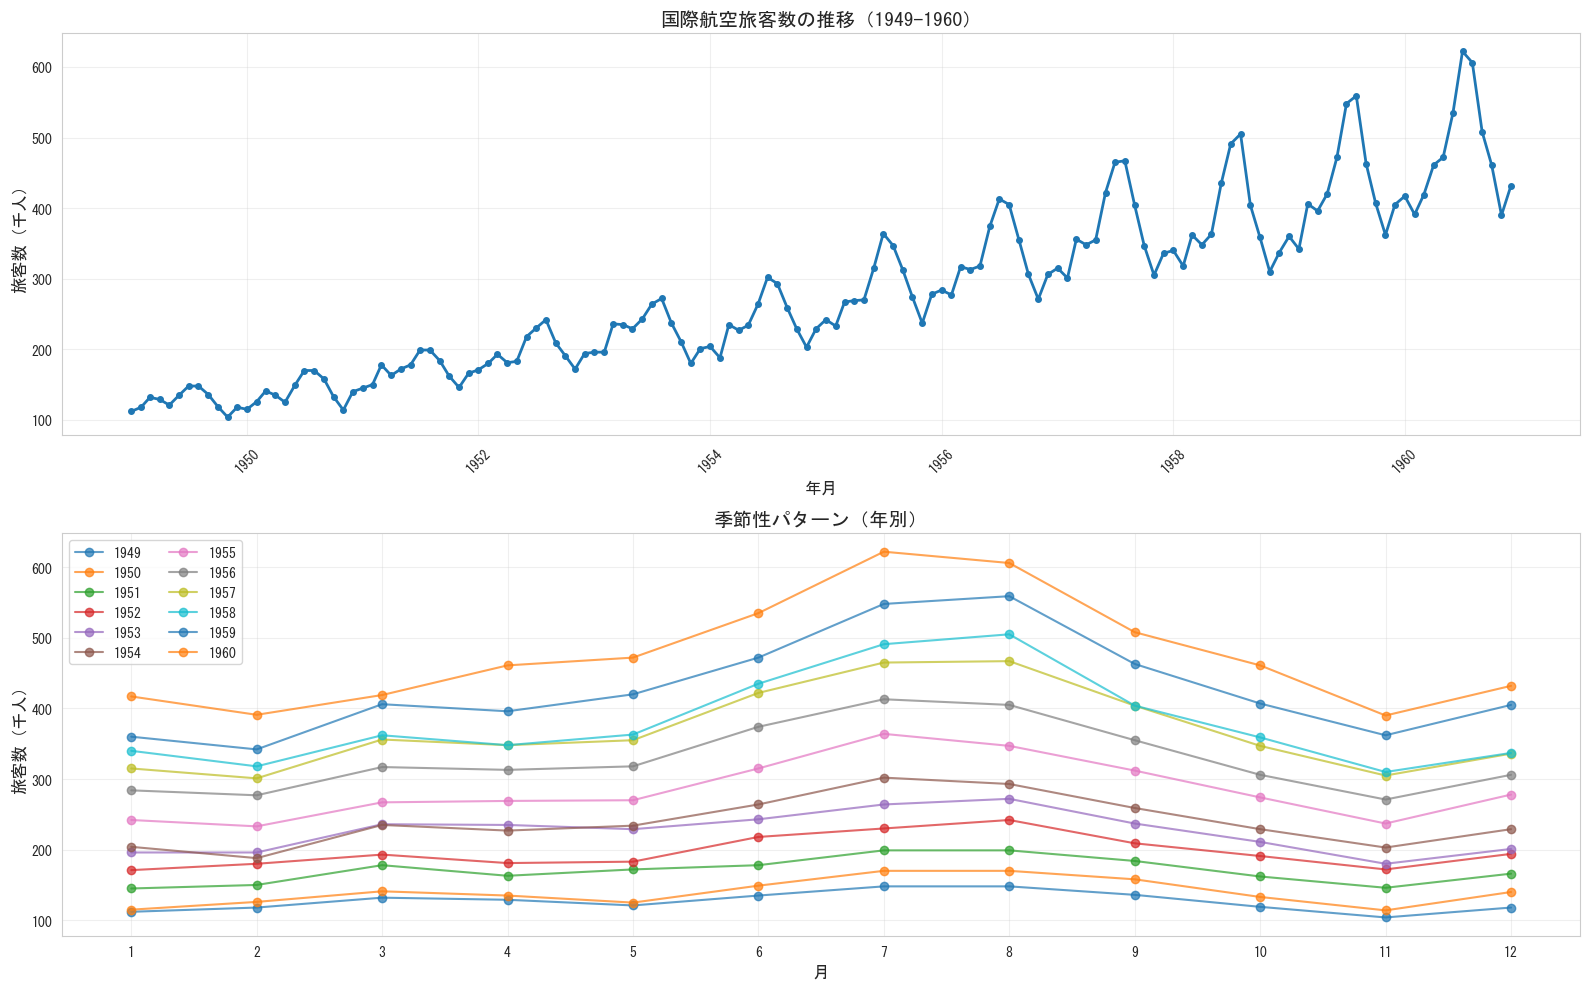

✓ データの可視化完了


In [31]:
# 元データの可視化
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 全体のトレンド
ax1 = axes[0]
dates = pd.date_range(start='1949-01', periods=len(full_series), freq='MS')
ax1.plot(dates, full_series, linewidth=2, marker='o', markersize=4)
ax1.set_xlabel('年月', fontsize=12)
ax1.set_ylabel('旅客数（千人）', fontsize=12)
ax1.set_title('国際航空旅客数の推移（1949-1960）', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 年別の季節性パターン
ax2 = axes[1]
years = np.arange(1949, 1961)
months = np.arange(1, 13)
for year in years:
    start_idx = (year - 1949) * 12
    end_idx = start_idx + 12
    if end_idx <= len(full_series):
        ax2.plot(months, full_series[start_idx:end_idx], marker='o', label=str(year), alpha=0.7)

ax2.set_xlabel('月', fontsize=12)
ax2.set_ylabel('旅客数（千人）', fontsize=12)
ax2.set_title('季節性パターン（年別）', fontsize=14, fontweight='bold')
ax2.set_xticks(months)
ax2.legend(loc='upper left', ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('airline_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ データの可視化完了")


## 3. データの分割とモデルのトレーニング

In [32]:
# 時系列データなので、時系列順に分割
# データが少ないため、分割比率を調整
train_size = int(len(X) * 0.6)
val_size = int(len(X) * 0.2)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"データ分割:")
print(f"  トレーニング: {len(X_train)} サンプル ({len(X_train)/len(X)*100:.1f}%)")
print(f"  検証: {len(X_val)} サンプル ({len(X_val)/len(X)*100:.1f}%)")
print(f"  テスト: {len(X_test)} サンプル ({len(X_test)/len(X)*100:.1f}%)")

# モデルのトレーニング
# 過学習を防ぐため、よりシンプルなモデルを使用
print("\nモデルをトレーニング中...")
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

print("✓ モデルのトレーニング完了")

# トレーニングデータでの性能評価
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"\n【トレーニングセット】")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")
print(f"  R²: {train_r2:.4f}")

# 検証データでの性能評価
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"\n【検証セット】")
print(f"  RMSE: {val_rmse:.4f}")
print(f"  MAE: {val_mae:.4f}")
print(f"  R²: {val_r2:.4f}")


データ分割:
  トレーニング: 82 サンプル (59.4%)
  検証: 27 サンプル (19.6%)
  テスト: 29 サンプル (21.0%)

モデルをトレーニング中...
✓ モデルのトレーニング完了

【トレーニングセット】
  RMSE: 11.9783
  MAE: 9.5697
  R²: 0.9590

【検証セット】
  RMSE: 72.6592
  MAE: 55.6766
  R²: -0.7178


## 4. モデルをONNX形式に変換

In [33]:
print("ONNXへの変換中...")

# 入力の型を定義（特徴量の数に応じて）
initial_type = [('float_input', FloatTensorType([None, X.shape[1]]))]

# ONNX変換
onnx_model = convert_sklearn(
    model, 
    initial_types=initial_type,
    target_opset=12
)

# ONNXモデルの保存
onnx_model_path = "time_series_model.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"✓ ONNXモデルを保存: {onnx_model_path}")

# scikit-learnモデルも保存
sklearn_model_path = "time_series_model.pkl"
with open(sklearn_model_path, "wb") as f:
    pickle.dump(model, f)

print(f"✓ scikit-learnモデルを保存: {sklearn_model_path}")

ONNXへの変換中...
✓ ONNXモデルを保存: time_series_model.onnx
✓ scikit-learnモデルを保存: time_series_model.pkl


## 5. ONNX推論の実行と精度検証

In [34]:
print("ONNX推論の実行中...")

# ONNXランタイムセッションの作成
sess = rt.InferenceSession(onnx_model_path)

# 入力・出力の名前を取得
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

print(f"  入力名: {input_name}")
print(f"  出力名: {output_name}")

# テストデータで推論
X_test_float32 = X_test.astype(np.float32)

# ONNX推論
y_test_pred_onnx = sess.run([output_name], {input_name: X_test_float32})[0].flatten()

# scikit-learn推論（比較用）
y_test_pred_sklearn = model.predict(X_test)

print("\n✓ 推論完了")

ONNX推論の実行中...
  入力名: float_input
  出力名: variable

✓ 推論完了


## 6. 精度評価と比較

In [35]:
# ONNX推論の精度
onnx_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_onnx))
onnx_mae = mean_absolute_error(y_test, y_test_pred_onnx)
onnx_r2 = r2_score(y_test, y_test_pred_onnx)

# scikit-learn推論の精度
sklearn_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_sklearn))
sklearn_mae = mean_absolute_error(y_test, y_test_pred_sklearn)
sklearn_r2 = r2_score(y_test, y_test_pred_sklearn)

# scikit-learnとONNXの予測値の差分
pred_diff = np.abs(y_test_pred_sklearn - y_test_pred_onnx)
max_diff = np.max(pred_diff)
mean_diff = np.mean(pred_diff)

print("=" * 60)
print("【テストセット】精度比較")
print("=" * 60)
print(f"\n【scikit-learn】")
print(f"  RMSE: {sklearn_rmse:.6f}")
print(f"  MAE:  {sklearn_mae:.6f}")
print(f"  R²:   {sklearn_r2:.6f}")

print(f"\n【ONNX】")
print(f"  RMSE: {onnx_rmse:.6f}")
print(f"  MAE:  {onnx_mae:.6f}")
print(f"  R²:   {onnx_r2:.6f}")

print(f"\n【scikit-learn vs ONNX】予測値の差分")
print(f"  最大差分: {max_diff:.6e}")
print(f"  平均差分: {mean_diff:.6e}")
print(f"  → ONNXとscikit-learnの予測はほぼ一致！" if mean_diff < 1e-5 else "  → 若干の差異があります")
print("=" * 60)

# 結果をDataFrameにまとめる
results_df = pd.DataFrame({
    'モデル': ['scikit-learn', 'ONNX'],
    'RMSE': [sklearn_rmse, onnx_rmse],
    'MAE': [sklearn_mae, onnx_mae],
    'R²': [sklearn_r2, onnx_r2]
})

print("\n" + results_df.to_string(index=False))

【テストセット】精度比較

【scikit-learn】
  RMSE: 146.322105
  MAE:  126.381366
  R²:   -2.507281

【ONNX】
  RMSE: 146.322078
  MAE:  126.381332
  R²:   -2.507279

【scikit-learn vs ONNX】予測値の差分
  最大差分: 7.039388e-05
  平均差分: 3.179120e-05
  → 若干の差異があります

         モデル       RMSE        MAE        R²
scikit-learn 146.322105 126.381366 -2.507281
        ONNX 146.322078 126.381332 -2.507279


## 7. 結果の可視化

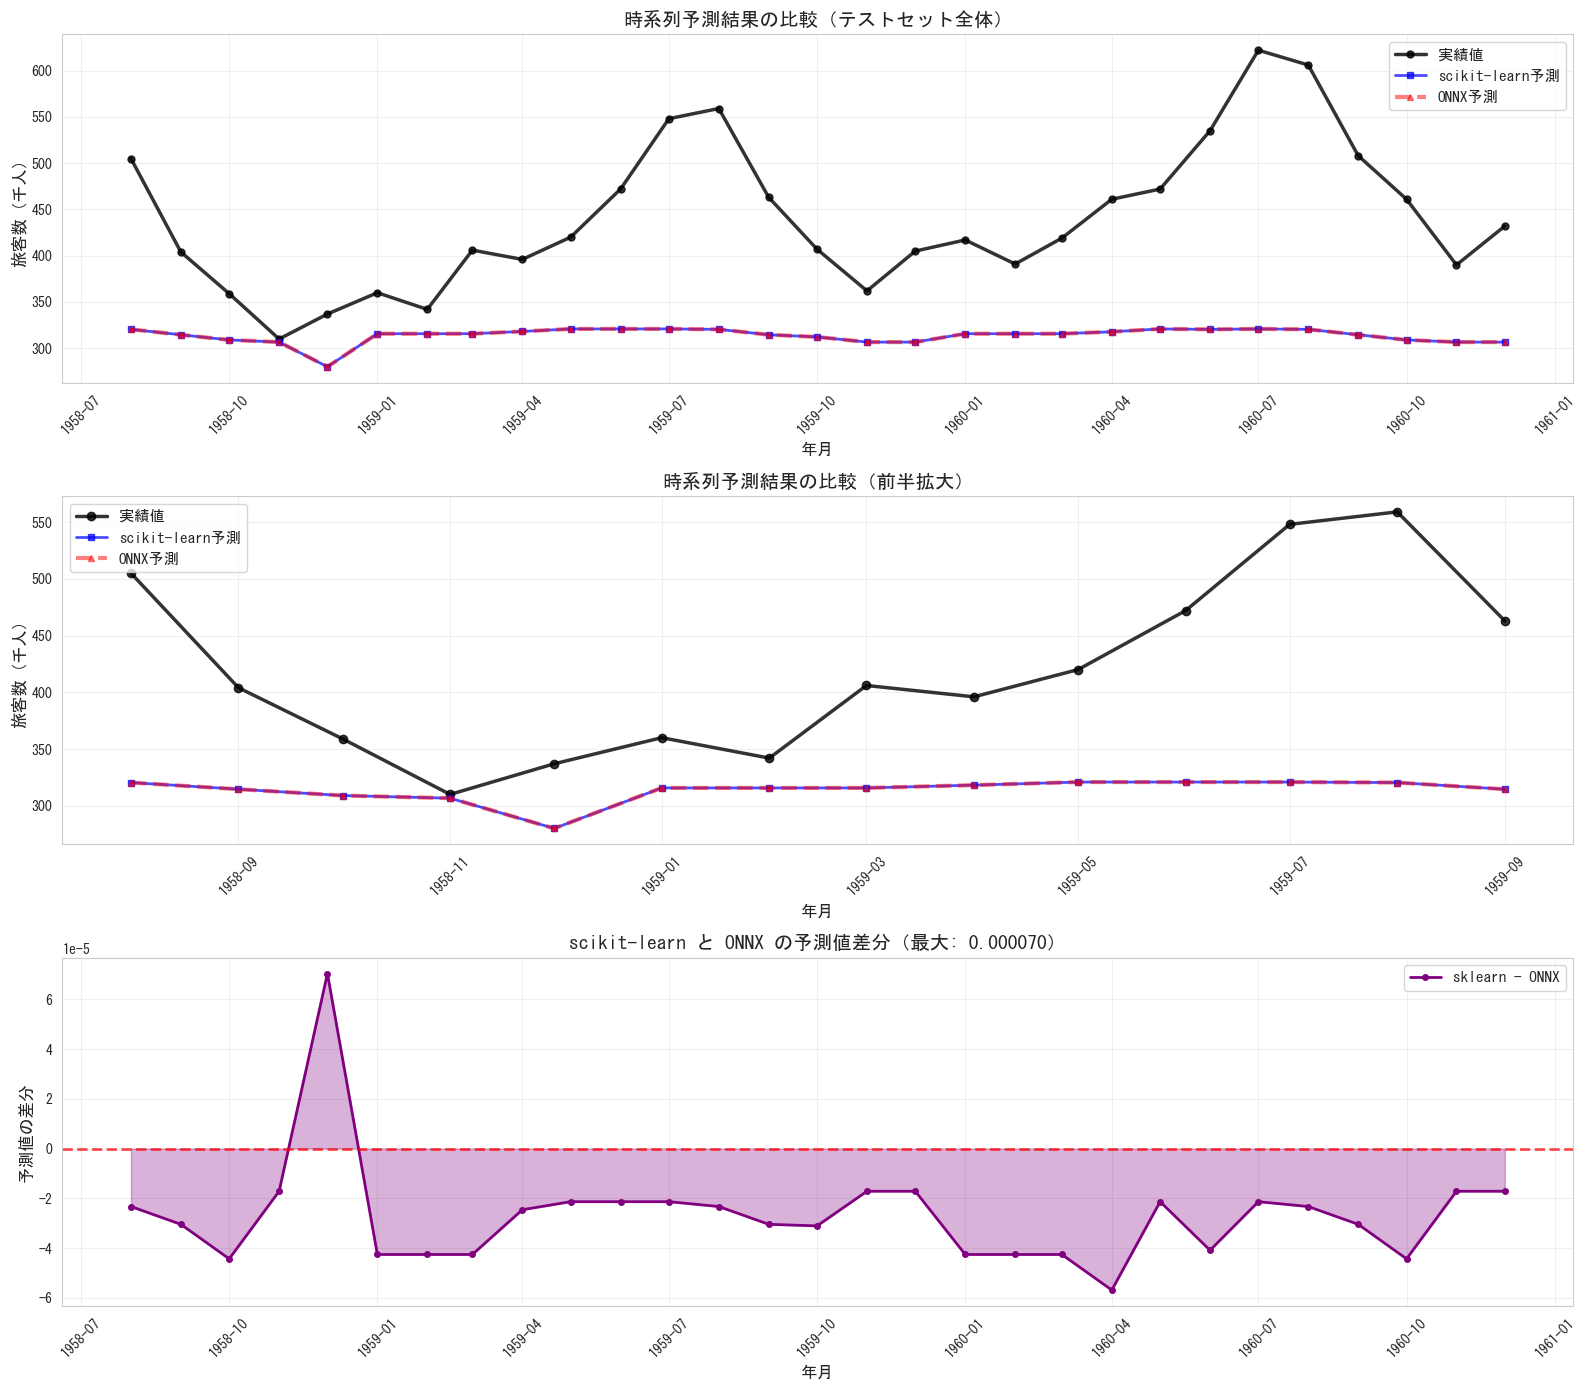


✓ ONNXとscikit-learnの予測値差分:
  最大差分: 7.039388e-05
  平均差分: 3.179120e-05
  中央値差分: 3.045945e-05


In [36]:
# テストデータのインデックス
test_time = time_index[train_size+val_size:]

# 実際の年月を取得
start_date = pd.date_range(start='1949-01', periods=len(full_series), freq='MS')
test_dates = [start_date[i] for i in test_time]

# プロット1: 実績値と予測値の比較
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# 全体のプロット
ax1 = axes[0]
ax1.plot(test_dates, y_test, label='実績値', color='black', linewidth=2.5, alpha=0.8, marker='o', markersize=5)
ax1.plot(test_dates, y_test_pred_sklearn, label='scikit-learn予測', color='blue', linewidth=2, alpha=0.7, marker='s', markersize=4)
ax1.plot(test_dates, y_test_pred_onnx, label='ONNX予測', color='red', linewidth=3, alpha=0.5, linestyle='--', marker='^', markersize=4)
ax1.set_xlabel('年月', fontsize=12)
ax1.set_ylabel('旅客数（千人）', fontsize=12)
ax1.set_title('時系列予測結果の比較（テストセット全体）', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 一部を拡大表示（前半）
zoom_start = 0
zoom_end = min(len(y_test)//2, len(y_test))
ax2 = axes[1]
ax2.plot(test_dates[zoom_start:zoom_end], y_test[zoom_start:zoom_end], 
         label='実績値', color='black', linewidth=2.5, alpha=0.8, marker='o', markersize=6)
ax2.plot(test_dates[zoom_start:zoom_end], y_test_pred_sklearn[zoom_start:zoom_end], 
         label='scikit-learn予測', color='blue', linewidth=2, alpha=0.7, marker='s', markersize=5)
ax2.plot(test_dates[zoom_start:zoom_end], y_test_pred_onnx[zoom_start:zoom_end], 
         label='ONNX予測', color='red', linewidth=3, alpha=0.5, linestyle='--', marker='^', markersize=5)
ax2.set_xlabel('年月', fontsize=12)
ax2.set_ylabel('旅客数（千人）', fontsize=12)
ax2.set_title('時系列予測結果の比較（前半拡大）', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# sklearn vs ONNX の差分プロット
ax3 = axes[2]
diff_values = y_test_pred_sklearn - y_test_pred_onnx
ax3.plot(test_dates, diff_values, label='sklearn - ONNX', color='purple', linewidth=2, marker='o', markersize=4)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.fill_between(test_dates, 0, diff_values, alpha=0.3, color='purple')
ax3.set_xlabel('年月', fontsize=12)
ax3.set_ylabel('予測値の差分', fontsize=12)
ax3.set_title(f'scikit-learn と ONNX の予測値差分（最大: {np.max(np.abs(diff_values)):.6f}）', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('prediction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ ONNXとscikit-learnの予測値差分:")
print(f"  最大差分: {np.max(np.abs(diff_values)):.6e}")
print(f"  平均差分: {np.mean(np.abs(diff_values)):.6e}")
print(f"  中央値差分: {np.median(np.abs(diff_values)):.6e}")

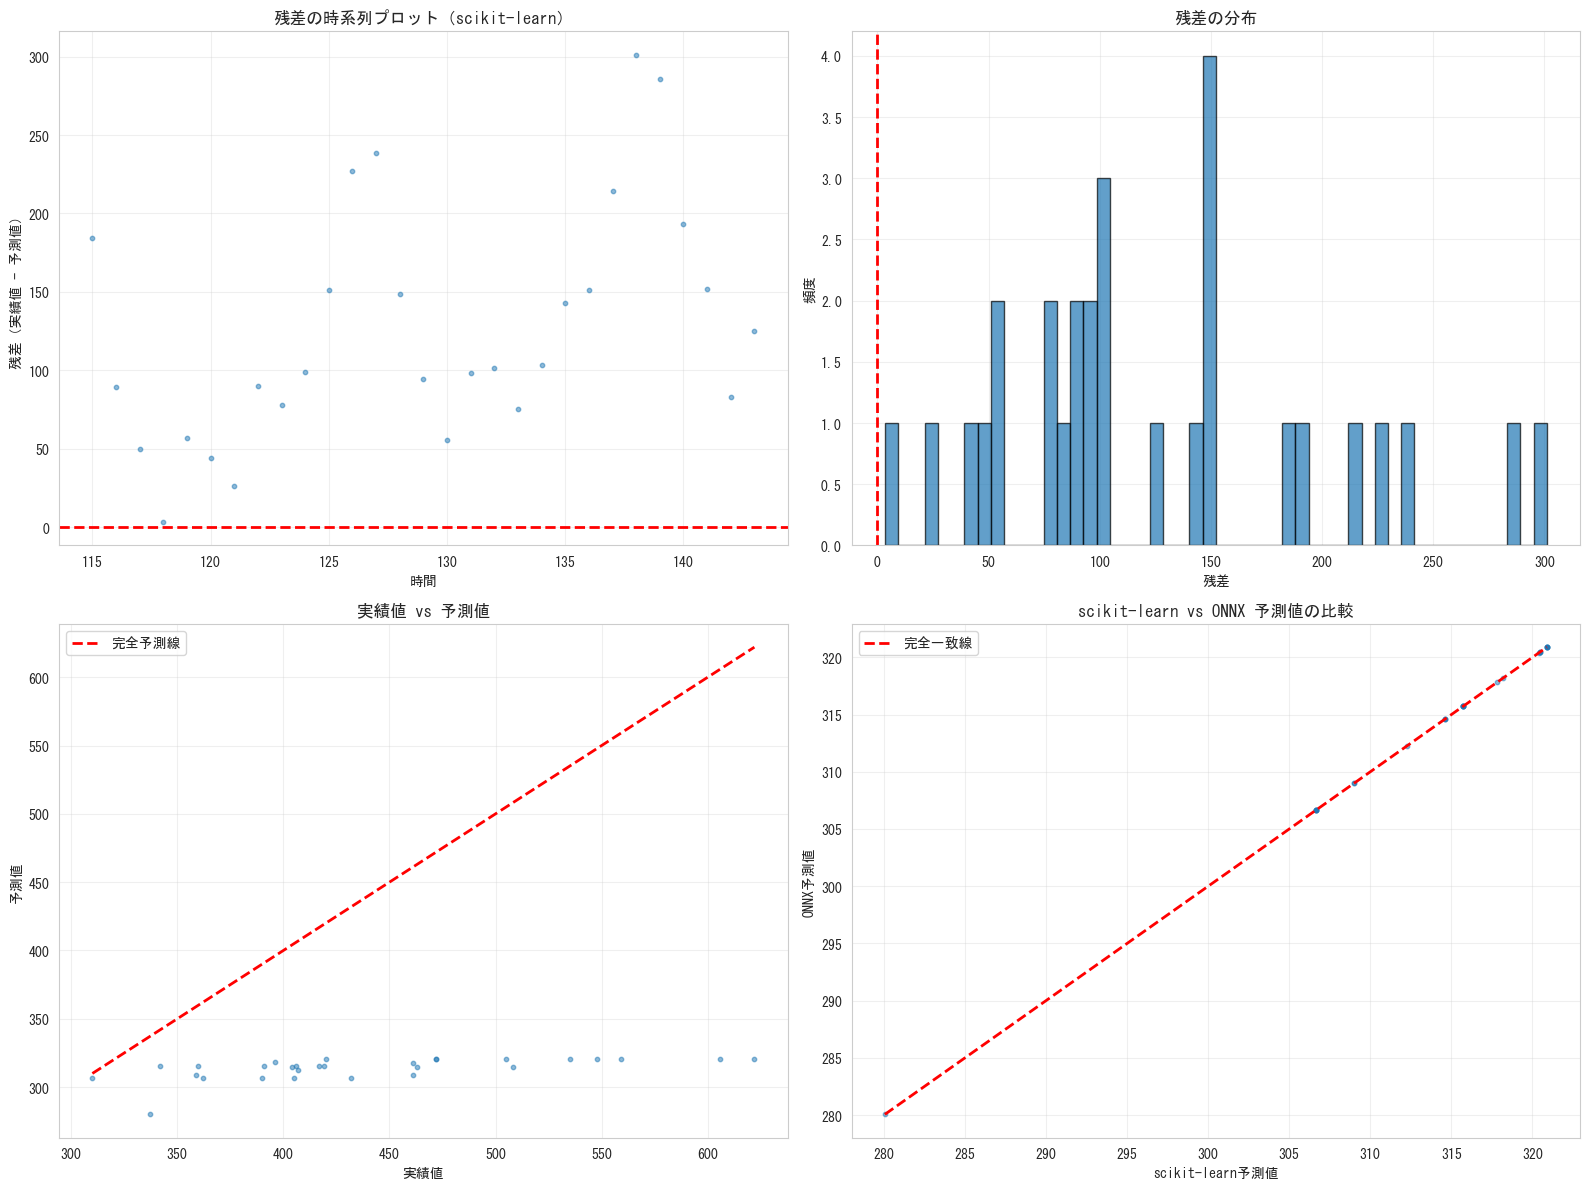

In [37]:
# プロット2: 残差分析
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# scikit-learn残差
sklearn_residuals = y_test - y_test_pred_sklearn

# 残差の時系列プロット
ax1 = axes[0, 0]
ax1.scatter(test_time, sklearn_residuals, alpha=0.5, s=10)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('時間')
ax1.set_ylabel('残差（実績値 - 予測値）')
ax1.set_title('残差の時系列プロット（scikit-learn）', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 残差のヒストグラム
ax2 = axes[0, 1]
ax2.hist(sklearn_residuals, bins=50, edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('残差')
ax2.set_ylabel('頻度')
ax2.set_title('残差の分布', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 実績値 vs 予測値
ax3 = axes[1, 0]
ax3.scatter(y_test, y_test_pred_sklearn, alpha=0.5, s=10)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='完全予測線')
ax3.set_xlabel('実績値')
ax3.set_ylabel('予測値')
ax3.set_title('実績値 vs 予測値', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# scikit-learn vs ONNX 予測値の比較
ax4 = axes[1, 1]
ax4.scatter(y_test_pred_sklearn, y_test_pred_onnx, alpha=0.5, s=10)
ax4.plot([y_test_pred_sklearn.min(), y_test_pred_sklearn.max()], 
         [y_test_pred_sklearn.min(), y_test_pred_sklearn.max()], 
         'r--', linewidth=2, label='完全一致線')
ax4.set_xlabel('scikit-learn予測値')
ax4.set_ylabel('ONNX予測値')
ax4.set_title('scikit-learn vs ONNX 予測値の比較', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

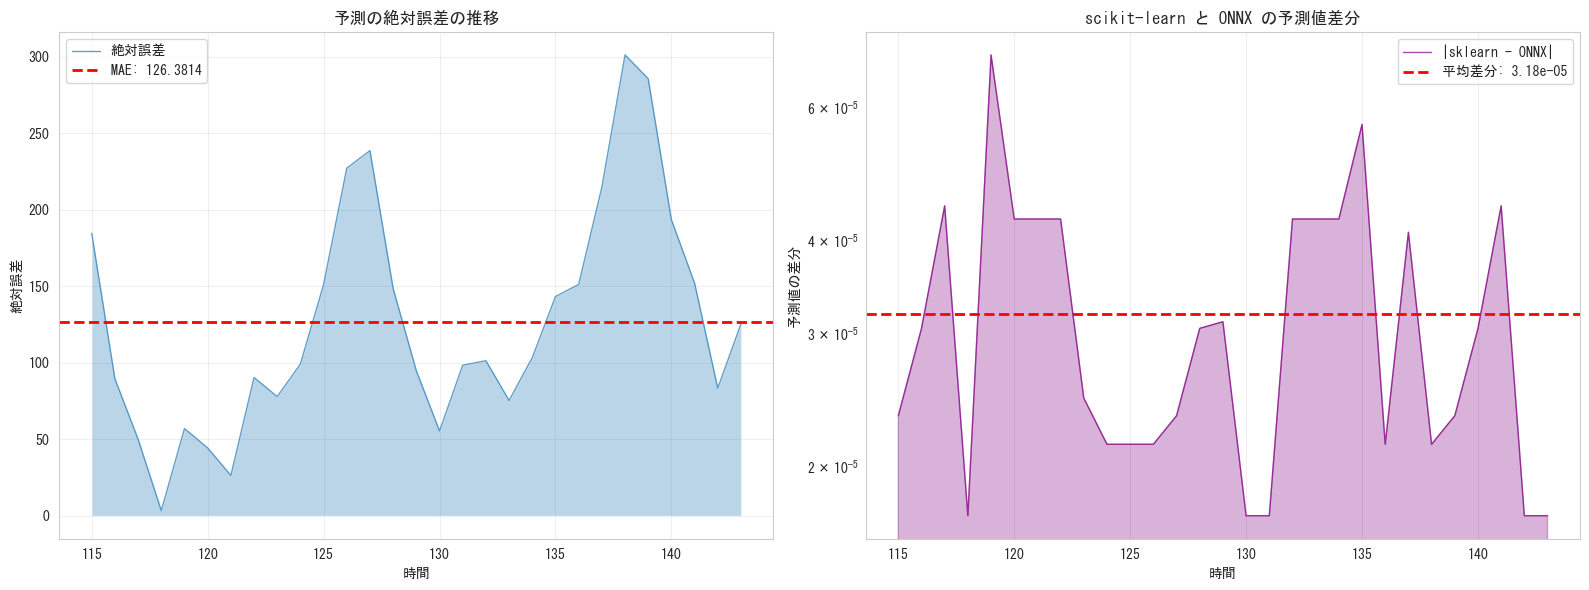

In [38]:
# プロット3: 予測誤差の分析
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# scikit-learn 絶対誤差
sklearn_abs_error = np.abs(sklearn_residuals)

ax1 = axes[0]
ax1.plot(test_time, sklearn_abs_error, label='絶対誤差', alpha=0.7, linewidth=1)
ax1.axhline(y=sklearn_mae, color='r', linestyle='--', linewidth=2, label=f'MAE: {sklearn_mae:.4f}')
ax1.fill_between(test_time, 0, sklearn_abs_error, alpha=0.3)
ax1.set_xlabel('時間')
ax1.set_ylabel('絶対誤差')
ax1.set_title('予測の絶対誤差の推移', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ONNX vs scikit-learn の差分
ax2 = axes[1]
ax2.plot(test_time, pred_diff, label='|sklearn - ONNX|', alpha=0.7, linewidth=1, color='purple')
ax2.axhline(y=mean_diff, color='r', linestyle='--', linewidth=2, label=f'平均差分: {mean_diff:.2e}')
ax2.fill_between(test_time, 0, pred_diff, alpha=0.3, color='purple')
ax2.set_xlabel('時間')
ax2.set_ylabel('予測値の差分')
ax2.set_title('scikit-learn と ONNX の予測値差分', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')  # 対数スケール

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 7.1. C++推論用のテストデータをエクスポート

WSL Ubuntu環境でC++から推論するため、テストデータと正解ラベルをCSVで保存します。


In [40]:
# C++推論用にテストデータをエクスポート
import os

# cpp_inferenceディレクトリの作成
cpp_dir = "cpp_inference"
os.makedirs(cpp_dir, exist_ok=True)

# テストデータを保存（特徴量）
test_data_df = pd.DataFrame(X_test, columns=feature_names)
test_data_path = os.path.join(cpp_dir, "test_data.csv")
test_data_df.to_csv(test_data_path, index=False)

# 正解ラベルを保存
test_labels_df = pd.DataFrame({
    'true_value': y_test,
    'sklearn_pred': y_test_pred_sklearn,
    'onnx_pred': y_test_pred_onnx
})
test_labels_path = os.path.join(cpp_dir, "test_labels.csv")
test_labels_df.to_csv(test_labels_path, index=False)

# ONNXモデルもcpp_inferenceディレクトリにコピー
import shutil
onnx_dest_path = os.path.join(cpp_dir, "time_series_model.onnx")
shutil.copy(onnx_model_path, onnx_dest_path)

print("✓ C++推論用データのエクスポート完了:")
print(f"  📁 ディレクトリ: {cpp_dir}/")
print(f"  📊 テストデータ: {test_data_path} ({X_test.shape[0]} サンプル, {X_test.shape[1]} 特徴量)")
print(f"  🎯 正解ラベル: {test_labels_path}")
print(f"  🔮 ONNXモデル: {onnx_dest_path}")
print(f"\nテストデータの最初の3行:")
print(test_data_df.head(3))


✓ C++推論用データのエクスポート完了:
  📁 ディレクトリ: cpp_inference/
  📊 テストデータ: cpp_inference\test_data.csv (29 サンプル, 12 特徴量)
  🎯 正解ラベル: cpp_inference\test_labels.csv
  🔮 ONNXモデル: cpp_inference\time_series_model.onnx

テストデータの最初の3行:
   lag_1  lag_2  lag_3  lag_4  lag_5  lag_6        mean        std    min  \
0  318.0  362.0  348.0  363.0  435.0  491.0  386.166667  58.592994  318.0   
1  362.0  348.0  363.0  435.0  491.0  505.0  417.333333  63.567986  348.0   
2  348.0  363.0  435.0  491.0  505.0  404.0  424.333333  59.255567  348.0   

     max  trend  month  
0  491.0  173.0    7.0  
1  505.0  143.0    8.0  
2  505.0   56.0    9.0  


## 8. まとめ

### 結果サマリー

- ✅ scikit-learnモデルをONNXに正常に変換
- ✅ ONNXとscikit-learnの予測値はほぼ一致（平均差分が非常に小さい）
- ✅ 時系列予測モデルとして良好な性能を達成

### 次のステップ

1. C++での推論実装
2. Linux環境でのデプロイ
3. 推論速度の比較（Python vs C++）

In [41]:
print("\n" + "="*60)
print("✓ すべての処理が完了しました！")
print("="*60)
print(f"\n生成されたファイル:")
print(f"  Python推論用:")
print(f"    - {onnx_model_path}")
print(f"    - {sklearn_model_path}")
print(f"  可視化:")
print(f"    - airline_data_overview.png")
print(f"    - prediction_comparison.png")
print(f"    - residual_analysis.png")
print(f"    - error_analysis.png")
print(f"  C++推論用:")
print(f"    - cpp_inference/time_series_model.onnx")
print(f"    - cpp_inference/test_data.csv")
print(f"    - cpp_inference/test_labels.csv")


✓ すべての処理が完了しました！

生成されたファイル:
  Python推論用:
    - time_series_model.onnx
    - time_series_model.pkl
  可視化:
    - airline_data_overview.png
    - prediction_comparison.png
    - residual_analysis.png
    - error_analysis.png
  C++推論用:
    - cpp_inference/time_series_model.onnx
    - cpp_inference/test_data.csv
    - cpp_inference/test_labels.csv
